# LSTM

In [1]:
#import packages
import numpy as np
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import random
import math
from datetime import datetime
import pickle
import pandas as pd
%matplotlib inline

#predefined activation function and its derivative
def Sigmoid(x): 
    return 1. / (1 + np.exp(-x))

def dSigmoid(values): 
    return values*(1-values)

def Tanh(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def dtanh(values): 
    return 1. - values**2

def rand_arr(a, b, *args): 
    seed(0)
    return rand(*args)*(b - a) + a

#LSTM Class
class LSTM:
    def __init__(self, X_dim, y_dim, neuron):
        
        self.X_dim = X_dim 
        self.y_dim = y_dim
        self.neuron = neuron
        
        #initiate weight
        self.weight_f = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_i = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_g = rand_arr(-0.1, 0.1, neuron, X_dim + neuron) 
        self.weight_o = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_out = rand_arr(-0.1, 0.1, y_dim, neuron)
        
        #initiate bias
        self.bias_f = rand_arr(-0.1, 0.1, neuron) 
        self.bias_i = rand_arr(-0.1, 0.1, neuron) 
        self.bias_g = rand_arr(-0.1, 0.1, neuron) 
        self.bias_o = rand_arr(-0.1, 0.1, neuron)
        self.bias_out = rand_arr(-0.1, 0.1, y_dim)
    
    def forward(self, inputs, outputs):
        X = inputs
        y = outputs
        
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        #show error
        #print(np.array(self.error).mean())
    
    def backward(self, inputs, outputs):
        self.diff_out = []
        self.diff_h = []
        self.diff_h_bottom = [zeros(self.neuron)]
        self.diff_s_up = [zeros(self.neuron)]
        self.diff_s = []
        self.diff_o = []
        self.diff_g = []
        self.diff_i = []
        self.diff_f = []
        for i in range(len(inputs)-1,-1,-1):
            #derivate of output
            if i == len(inputs)-1:
                self.diff_out  = [2*(self.out[i] - outputs[i])] + self.diff_out
                self.diff_h = [self.diff_out[0]*dSigmoid(self.weight_out@self.h[i+1] + self.bias_out)*self.weight_out + self.diff_h_bottom[0]] + self.diff_h
            else:
                self.diff_h = [self.diff_h_bottom[0]] + self.diff_h
            
            
            #derivative of gate/neural network operation
            self.diff_s = [self.diff_h[0]*self.o[i]*dtanh(self.s[i+1]) + self.diff_s_up[0]] + self.diff_s
            self.diff_o = [self.diff_h[0]*Tanh(self.s[i+1])] + self.diff_o
            self.diff_g = [self.i[i]*self.diff_s[0]] + self.diff_g
            self.diff_i = [self.g[i]*self.diff_s[0]] + self.diff_i
            self.diff_f = [self.s[i]*self.diff_s[0]] + self.diff_f
            
            #derivative of concatenation of input dan previous output value
            self.dX_concat = (self.diff_o[0].T*(dSigmoid(self.o[i]).reshape(self.neuron,1))).T@self.weight_o
            self.dX_concat += (self.diff_g[0].T*(dSigmoid(self.g[i]).reshape(self.neuron,1))).T@self.weight_g
            self.dX_concat += (self.diff_i[0].T*(dSigmoid(self.i[i]).reshape(self.neuron,1))).T@self.weight_i
            self.dX_concat += (self.diff_f[0].T*(dSigmoid(self.f[i]).reshape(self.neuron,1))).T@self.weight_f
            
            #update value of long and short term memory
            self.diff_h_bottom = [self.dX_concat[-1][self.X_dim:]] + self.diff_h_bottom
            self.diff_s_up = [self.diff_s[0]*self.f[i]] + self.diff_s_up
            
    def update(self, alpha):
        
        #alpha 
        
        #update everyweight and bias
        self.weight_out -= alpha*self.diff_out[0].reshape(1,1)@self.h[1].T.reshape(1,self.neuron)
        self.bias_out -= alpha*self.diff_out[0]
        
        self.weight_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).reshape(self.neuron,)
        
        self.weight_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).reshape(self.neuron,)
        
        self.weight_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).reshape(self.neuron,)
        
        self.weight_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).T.reshape(self.neuron,1)@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).reshape(self.neuron,)
    
    def predict(self, inputs, outputs):
        X = inputs
        y = outputs
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        
        return [self.out[-1][0],self.y[-1]]
    
    def show_progress(self):
        return abs(self.y[-1][0] - self.out[-1])

# Change the Indicators Here!

In [2]:
#hyperparameters
epochs  = 1000
nc      = 10 #units

#datasets
name_of_dataset = 'PSDN-long.csv'
name_dataset = 'PSDN-long'

column_dataset_obs = 'Close'

# Import Dataset

In [3]:
df = pd.read_csv('../../Datasets/'+name_of_dataset)
df.drop('Volume', inplace=True, axis=1)
df

,Date,Open,High,Low,Close,Adj Close
0,02/01/2017,134,134,134,134,134
1,03/01/2017,135,139,135,139,139
2,04/01/2017,139,139,136,136,136
3,05/01/2017,135,141,135,141,141
4,06/01/2017,136,140,136,140,140
...,...,...,...,...,...,...
1257,24/12/2021,153,157,151,151,151
1258,27/12/2021,151,174,143,174,174
1259,28/12/2021,175,176,162,162,162
1260,29/12/2021,162,164,153,155,155


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close
count,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000
mean,197.896197,205.019810,191.425515,198.091125,198.091125
std,85.146566,91.846545,79.435152,85.358992,85.358992
min,94.000000,99.000000,94.000000,97.000000,97.000000
25%,142.000000,148.000000,139.000000,143.000000,143.000000
50%,178.000000,182.500000,171.000000,177.000000,177.000000
75%,226.000000,230.000000,220.000000,228.000000,228.000000
max,735.000000,815.000000,655.000000,735.000000,735.000000


In [5]:
new_df = df.reset_index()[column_dataset_obs]
new_df

0       134
1       139
2       136
3       141
4       140
       ... 
1257    151
1258    174
1259    162
1260    155
1261    153
Name: Close, Length: 1262, dtype: int64

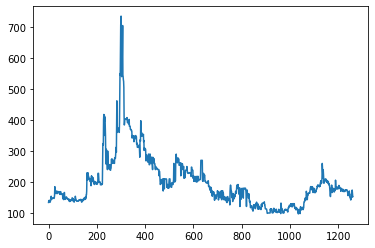

In [6]:
plt.plot(new_df)

# MinMax Scaler

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
new_df = scaler.fit_transform(np.array(new_df).reshape(-1,1))
# new_df

In [8]:
xs = new_df

In [9]:
#Standarized the dataset
N       = xs.shape[0]

#hypreparameter
Ts      = 1
x_dim   = 1
alpha   = 0.01 #learningrate

xt      = xs[0:N-x_dim,:]

for i in range(x_dim):
    xt  = hstack((xt, xs[i+1:N-x_dim+i+1]))   



# Splitting Training and Testing

In [10]:
training_size = int(len(new_df)*0.8)
test_size = len(new_df)-training_size

In [11]:
training_size, test_size

(1009, 253)

In [12]:
X_train = xt[:training_size, 0:x_dim]     
y_train = xt[:training_size, x_dim:x_dim+1]  
X_test = xt[-test_size:, 0:x_dim]     
y_test = xt[-test_size:, x_dim:x_dim+1]

## Build LSTM Model

In [13]:
me = LSTM(x_dim,1,nc)
for i in range(epochs):
    print('-------------',i+1,'-------------')
    for j in range(X_train.shape[0]-Ts):
        me.forward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.backward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.update(alpha)
    hehe = []
    for j in range(X_test.shape[0]-Ts):
        me.forward(X_test[j:j+Ts],y_test[j:j+Ts])
        me.backward(X_test[j:j+Ts],y_test[j:j+Ts])
        me.update(alpha)
        hehe.append(me.show_progress())    
    print(np.array(hehe).mean())

------------- 1 -------------
0.0290704713558652
------------- 2 -------------
0.02906447189214201
------------- 3 -------------
0.02905847420206463
------------- 4 -------------
0.029052478362037944
------------- 5 -------------
0.029046484456274255
------------- 6 -------------
0.029040492568497406
------------- 7 -------------
0.02903450278188486
------------- 8 -------------
0.029028515179010093
------------- 9 -------------
0.02902252984178542
------------- 10 -------------
0.02901654685140493
------------- 11 -------------
0.02901056628828796
------------- 12 -------------
0.029004588232022923
------------- 13 -------------
0.028998612761311465
------------- 14 -------------
0.02899263995391289
------------- 15 -------------
0.028986669886589326
------------- 16 -------------
0.02898070263505092
------------- 17 -------------
0.02897473827390177
------------- 18 -------------
0.02896877687658599
------------- 19 -------------
0.028962818515334478
------------- 20 -------------
0.

0.02815865175247713
------------- 159 -------------
0.02815262619964222
------------- 160 -------------
0.028146584969531985
------------- 161 -------------
0.028140527646949354
------------- 162 -------------
0.028134453811617346
------------- 163 -------------
0.028128363038139335
------------- 164 -------------
0.028122254895958137
------------- 165 -------------
0.028116128949313788
------------- 166 -------------
0.028109984757200883
------------- 167 -------------
0.028103821873324216
------------- 168 -------------
0.02809763984605375
------------- 169 -------------
0.02809143821837835
------------- 170 -------------
0.028085216527858312
------------- 171 -------------
0.028078974306576833
------------- 172 -------------
0.02807271108109031
------------- 173 -------------
0.02806642637237734
------------- 174 -------------
0.028060119695786638
------------- 175 -------------
0.028053790560983588
------------- 176 -------------
0.0280474384718956
------------- 177 -------------
0

0.026549100729920658
------------- 318 -------------
0.026529865458260495
------------- 319 -------------
0.026510414462960444
------------- 320 -------------
0.0264907447377141
------------- 321 -------------
0.02647085323724885
------------- 322 -------------
0.026450736876979655
------------- 323 -------------
0.02643039253267045
------------- 324 -------------
0.026409817040102954
------------- 325 -------------
0.02638900719475395
------------- 326 -------------
0.026367959751482043
------------- 327 -------------
0.02634667142422348
------------- 328 -------------
0.026325138885699113
------------- 329 -------------
0.026303358767132197
------------- 330 -------------
0.02628132765797824
------------- 331 -------------
0.02625904210566762
------------- 332 -------------
0.02623649861536167
------------- 333 -------------
0.02621369364972334
------------- 334 -------------
0.026190623628702874
------------- 335 -------------
0.026167284929339955
------------- 336 -------------
0.0

0.018470484106922553
------------- 474 -------------
0.018373624196603953
------------- 475 -------------
0.018276213419510655
------------- 476 -------------
0.018178584230123803
------------- 477 -------------
0.018082066981289415
------------- 478 -------------
0.017985039509888435
------------- 479 -------------
0.01788751238394139
------------- 480 -------------
0.017789496545238613
------------- 481 -------------
0.0176910033113915
------------- 482 -------------
0.01759208992324801
------------- 483 -------------
0.01749324814106221
------------- 484 -------------
0.017394172916081904
------------- 485 -------------
0.017295562968053884
------------- 486 -------------
0.017197556250756148
------------- 487 -------------
0.017099437592759177
------------- 488 -------------
0.017001493532666116
------------- 489 -------------
0.016903190310974682
------------- 490 -------------
0.01680454214103466
------------- 491 -------------
0.01670556358877312
------------- 492 -------------


0.008412833270089234
------------- 630 -------------
0.008399287876985186
------------- 631 -------------
0.008385945605140532
------------- 632 -------------
0.008372804002145592
------------- 633 -------------
0.008359860628474693
------------- 634 -------------
0.008347113058142258
------------- 635 -------------
0.008334558879321913
------------- 636 -------------
0.008322195694928406
------------- 637 -------------
0.008310021123164825
------------- 638 -------------
0.008298032798035981
------------- 639 -------------
0.00828655717481158
------------- 640 -------------
0.008275661066324597
------------- 641 -------------
0.00826534606438453
------------- 642 -------------
0.008255515072334702
------------- 643 -------------
0.008245836556739211
------------- 644 -------------
0.00823630854415949
------------- 645 -------------
0.008226929077291242
------------- 646 -------------
0.008217696215214771
------------- 647 -------------
0.008208822266138836
------------- 648 ----------

0.007866292951081919
------------- 785 -------------
0.007866045060880823
------------- 786 -------------
0.007865805446964046
------------- 787 -------------
0.007865573971512602
------------- 788 -------------
0.007865350498831667
------------- 789 -------------
0.007865134895319642
------------- 790 -------------
0.007864927029437517
------------- 791 -------------
0.00786472677167812
------------- 792 -------------
0.007864533994536575
------------- 793 -------------
0.007864348572480606
------------- 794 -------------
0.007864170381921406
------------- 795 -------------
0.007863999301184935
------------- 796 -------------
0.007863835210483578
------------- 797 -------------
0.007863677991888215
------------- 798 -------------
0.007863527529300569
------------- 799 -------------
0.0078633837084261
------------- 800 -------------
0.00786324641674723
------------- 801 -------------
0.007863115543496831
------------- 802 -------------
0.007862990979632218
------------- 803 -----------

0.007876522089451865
------------- 943 -------------
0.007876709303338615
------------- 944 -------------
0.007876896781039935
------------- 945 -------------
0.007877084512251756
------------- 946 -------------
0.00787727248684938
------------- 947 -------------
0.007877460694884106
------------- 948 -------------
0.00787764912658072
------------- 949 -------------
0.007877837772334527
------------- 950 -------------
0.007878026622708761
------------- 951 -------------
0.007878215668431691
------------- 952 -------------
0.007878404900394063
------------- 953 -------------
0.00787859430964661
------------- 954 -------------
0.007878783887397227
------------- 955 -------------
0.007878973625008613
------------- 956 -------------
0.007879163513995686
------------- 957 -------------
0.00787935354602314
------------- 958 -------------
0.007879543712903132
------------- 959 -------------
0.007879734006592766
------------- 960 -------------
0.007879924419191785
------------- 961 -----------

In [14]:
import matplotlib.pyplot as plt

out = []
for j in range(X_test.shape[0]-Ts):
    out.append(me.predict(X_test[j:j+Ts],y_test[j:j+Ts]))

out=scaler.inverse_transform(out).tolist()

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## Report Performance of LSTM Predictions

In [15]:
from math import sqrt

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [16]:
# mse = mean_squared_error(y, predictions)
# print('MSE: '+str(mse))
print('epoch: ' + str(epochs))
print('units: ' + str(nc))

rmse = math.sqrt(mean_squared_error(np.array(out)[:,1], np.array(out)[:,0]))
print('RMSE: '+ str("{:.2f}".format(rmse)))
mae = mean_absolute_error(np.array(out)[:,1], np.array(out)[:,0])
print('MAE: '+ str("{:.2f}".format(mae)))
mape = mean_absolute_percentage_error(np.array(out)[:,1], np.array(out)[:,0])
print('MAPE: '+ str("{:.2f}".format(mape*100)))

epoch: 1000
units: 10
RMSE: 7.33
MAE: 5.10
MAPE: 3.15


## Visualize Test Data the Prediction and Real Stock

In [17]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

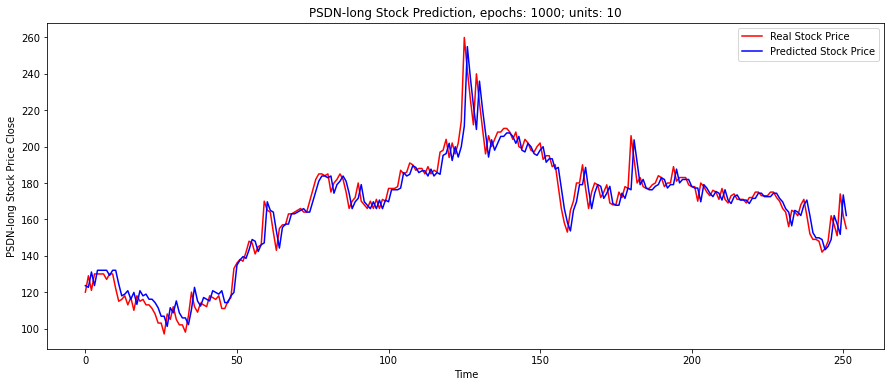

In [18]:
plt.figure()
plt.plot(np.array(out)[:,1], color = 'red', label = 'Real Stock Price')
plt.plot(np.array(out)[:,0], color = 'blue', label = 'Predicted Stock Price')
plt.title(name_dataset +' Stock Prediction, epochs: '+ str(epochs) +'; units: '+str(nc))
plt.xlabel('Time')
plt.ylabel(name_dataset +' Stock Price '+ column_dataset_obs)
plt.legend()

## Save as a new Dataset

In [19]:
real_price = np.array(out)[:,1]
close_lstm = np.array(out)[:,0]

In [20]:
new_data = {'real_price': real_price,
            'Close_LSTM': close_lstm}


In [23]:
df_new_data = pd.DataFrame(new_data, columns = ['real_price', 'Close_LSTM'])

print(df_new_data)

     real_price  Close_LSTM
0         120.0  123.582438
1         129.0  122.646177
2         121.0  131.079308
3         130.0  123.582438
4         130.0  132.017244
..          ...         ...
247       157.0  162.118065
248       151.0  157.404590
249       174.0  151.753094
250       162.0  173.443766
251       155.0  162.118065

[252 rows x 2 columns]


In [24]:
df_new_data.to_csv('../../Datasets/dataset after prediction/'+name_dataset
                   +'_LSTM_'+ str(epochs) +'_'+ str(nc) + '.csv', index=False)

## Save as a new Dataset